# Universal differential equation for SIR ODE model

In this notebook, we want to jointly estimate the parameter $\gamma$ of the known part of the mechanistic model and the parameters $\theta$ of the neural network, which is supposed to learn the unknown residual dynamics.

In [1]:
# SciML Tools
using OrdinaryDiffEq, SciMLSensitivity, Optimization, OptimizationOptimisers, OptimizationOptimJL

# Standard Libraries
using LinearAlgebra, Statistics, Random, Distributions

# External Libraries
using ComponentArrays, Lux, Zygote, Plots, StableRNGs
gr()

# Set a random seed for reproducible behaviour
rng = StableRNG(1111);

### Define the SIR dynamics and solve the ODE

In [2]:
function sir!(du, u, p, t)
    β, γ, N = p
    du[1] = -β*u[1]*u[2]/N
    du[2] = β*u[1]*u[2]/N - γ*u[2]
    du[3] = γ*u[2]
end

p_ODE = [0.6, 0.3, 1.0]
u0 = [0.999, 0.001, 0.0]
tspan = (0.0, 40.0);

In [3]:
prob = ODEProblem(sir!, u0, tspan, p_ODE)
sol = solve(prob, Tsit5(), abstol = 1e-12, reltol = 1e-12, saveat = 1.0);

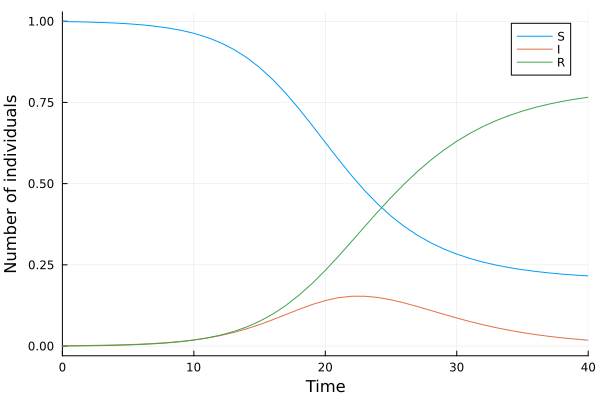

In [4]:
plot(sol, xlabel = "Time", ylabel = "Number of individuals", labels = ["S" "I" "R"])

### Add multiplicative log-normal noise

In [5]:
t = sol.t
X = Array(sol)
dist = LogNormal(0, 0.01)
noise = rand(rng, dist, size(X))
X_noisy = noise .* X;

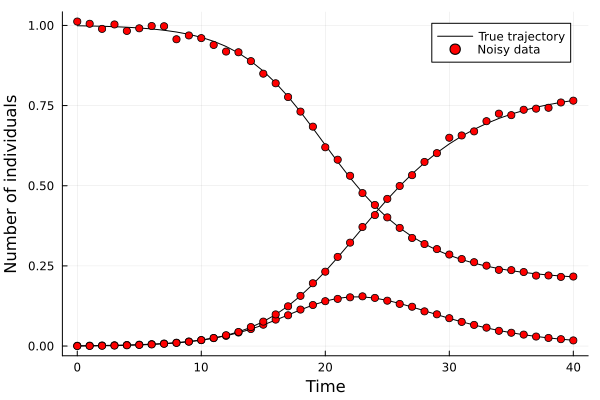

In [6]:
plot(t, X', xlabel = "Time", ylabel = "Number of individuals",
     color = :black, label=["True trajectory" nothing nothing])
scatter!(t, X_noisy', color = :red, label=["Noisy data" nothing nothing])

### Set up the UDE

We set up our UDE by first defining the NN component and then the hybrid model $u'=f(u, \gamma)+\text{NN}(u, \theta)$.

In [7]:
# Define activation function
rbf(x) = exp.(-(x .^ 2))

# Multi-layer feed-forward neural network
model = Chain(Dense(3, 5, rbf), Dense(5, 5, rbf), Dense(5, 5, rbf), Dense(5, 3))

# Get initial parameters and state variables of the model
θ_init, st = Lux.setup(rng, model);

In [8]:
# Define the hybrid model
β, γ, N = p_ODE

function ude_dynamics!(du, u, p, t)
    nn = Lux.apply(model, u, p.nn, st)[1]   # Network prediction    
    du[1] = nn[1]
    du[2] = -p.γ*u[2] + nn[2] 
    du[3] = p.γ*u[2] + nn[3]
end

γ_init = 0.5
p_init = (nn = θ_init, γ = γ_init)
p_init = ComponentVector(p_init)
prob_ude = ODEProblem(ude_dynamics!, u0, tspan, p_init);

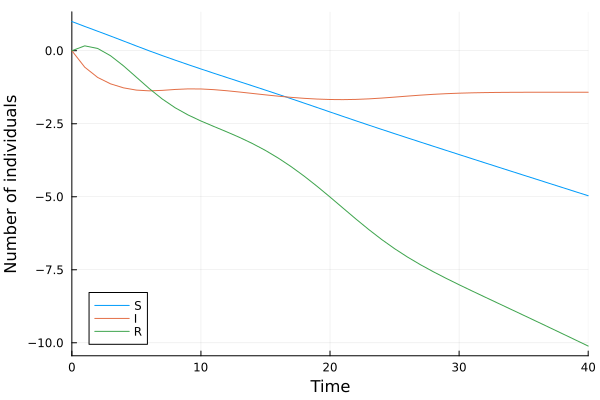

In [9]:
sol_ude_init = solve(prob_ude, Tsit5(), abstol = 1e-6, reltol = 1e-6, saveat = t)
plot(sol_ude_init, xlabel = "Time", ylabel = "Number of individuals", labels = ["S" "I" "R"])

### Set up the training

In [10]:
function predict(p)   # p consists of the NN parameters θ and the mechanistic parameter γ of the ODE
    _prob = remake(prob_ude, p=p)
    Array(solve(_prob, Tsit5(), abstol = 1e-6, reltol = 1e-6, saveat = t,
                sensealg=QuadratureAdjoint(autojacvec=ReverseDiffVJP(true))))
end;

In [11]:
function loss(p)
    X̂ = predict(p)
    mean(abs2, X_noisy .- X̂)   # MSE loss
end;

In [12]:
losses = Float64[]

function callback(p, l)
    push!(losses, l)
    n_iter = length(losses)
    if n_iter % 50 == 0   
        println("Loss after $(n_iter) iterations: $(losses[end])")
    end
    return false
end;

### Train the UDE

In [13]:
adtype = AutoZygote()   # automatic differentiation
optf = OptimizationFunction((p, _) -> loss(p), adtype)
optprob = OptimizationProblem(optf, p_init);

In [14]:
res1 = solve(optprob, ADAM(), callback = callback, maxiters = 5000);

Loss after 50 iterations: 0.5653239797236802
Loss after 100 iterations: 0.4091795619667782
Loss after 150 iterations: 0.30927807736857177
Loss after 200 iterations: 0.23708640570090977
Loss after 250 iterations: 0.18522340353059277
Loss after 300 iterations: 0.14769185976281232
Loss after 350 iterations: 0.12004599777196
Loss after 400 iterations: 0.09921490241348845
Loss after 450 iterations: 0.08315379455207655
Loss after 500 iterations: 0.07051340594152321
Loss after 550 iterations: 0.060392239990125135
Loss after 600 iterations: 0.05217231324781274
Loss after 650 iterations: 0.045416938247301517
Loss after 700 iterations: 0.039808636475891016
Loss after 750 iterations: 0.03511103218857671
Loss after 800 iterations: 0.03114484316805346
Loss after 850 iterations: 0.02777205896186132
Loss after 900 iterations: 0.024885161528014035
Loss after 950 iterations: 0.022399527031175155
Loss after 1000 iterations: 0.020247942574763388
Loss after 1050 iterations: 0.018376573315749427
Loss after

In [15]:
optprob2 = OptimizationProblem(optf, res1.u)
res2 = solve(optprob2, LBFGS(), callback = callback, maxiters = 1500)
p_trained = res2.u;

Loss after 5050 iterations: 0.0033233500216125465
Loss after 5100 iterations: 0.002289733251734177
Loss after 5150 iterations: 0.001972419260098535
Loss after 5200 iterations: 0.0006202333490775111
Loss after 5250 iterations: 0.00045034175894271276
Loss after 5300 iterations: 0.0002297210815597828
Loss after 5350 iterations: 9.595760956763114e-5
Loss after 5400 iterations: 7.625780547451957e-5
Loss after 5450 iterations: 7.214728091121596e-5
Loss after 5500 iterations: 6.08548558113841e-5
Loss after 5550 iterations: 4.581219844170307e-5
Loss after 5600 iterations: 4.185635460886158e-5
Loss after 5650 iterations: 3.999875542076622e-5
Loss after 5700 iterations: 3.91250095912209e-5
Loss after 5750 iterations: 3.218256307915388e-5
Loss after 5800 iterations: 3.1463578770237655e-5
Loss after 5850 iterations: 2.7570917014402342e-5
Loss after 5900 iterations: 2.5448839067162712e-5
Loss after 5950 iterations: 2.4487207786830285e-5
Loss after 6000 iterations: 2.4183350257826163e-5
Loss after 6

### Visualize the results

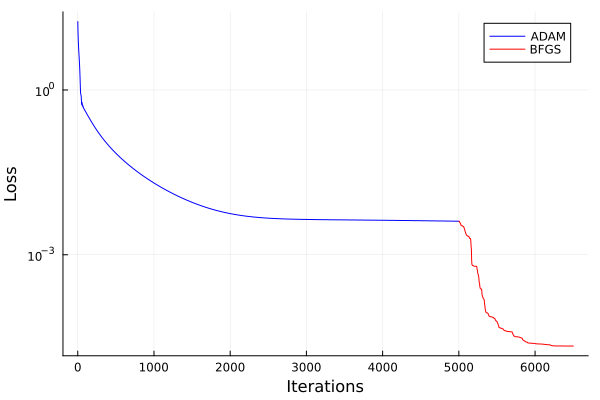

In [16]:
plot(1:5000, losses[1:5000], yaxis=:log10, xlabel="Iterations", ylabel="Loss", label="ADAM", color=:blue)
plot!(5001:length(losses), losses[5001:end], yaxis=:log10, label="BFGS", color = :red)

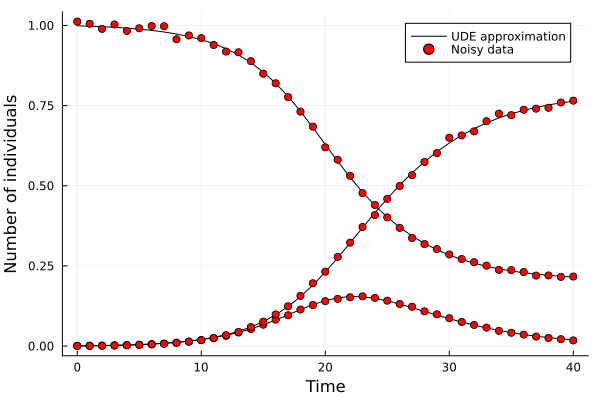

In [17]:
X̂ = predict(p_trained)
plot(t, X̂', xlabel = "Time", ylabel = "Number of individuals", color = :black,
     label = ["UDE approximation" nothing nothing])
scatter!(t, X_noisy', color = :red, label=["Noisy data" nothing nothing])

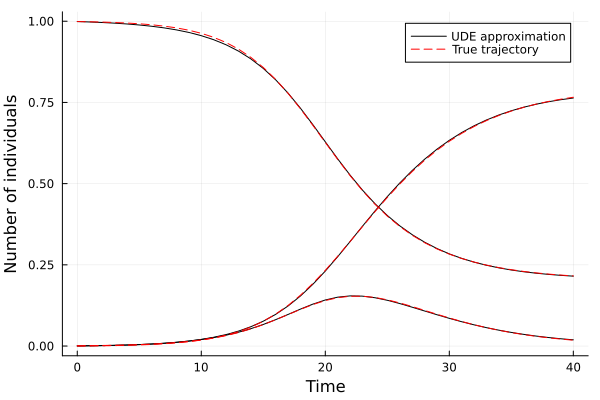

In [18]:
plot(t, X̂', xlabel = "Time", ylabel = "Number of individuals", color = :black,
     label = ["UDE approximation" nothing nothing])
plot!(t, X', color = :red, linestyle=:dash, label=["True trajectory" nothing nothing])

In [19]:
p_trained.γ

0.37615421966768925

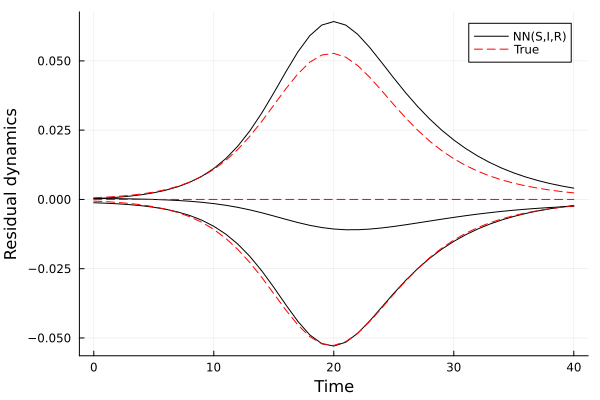

In [20]:
# True residual dynamics (i.e. interactions of predictors) along the true trajectory
dynamics_true = [-β/N * (X[1, :] .* X[2, :])'; β/N * (X[1, :] .* X[2, :])'; zeros(length(t))']
# Neural network guess along the true trajectory
dynamics_nn = Lux.apply(model, X, p_trained.nn, st)[1]

plot(t, dynamics_nn', xlabel = "Time", ylabel = "Residual dynamics", color = :black,
     label = ["NN(S,I,R)" nothing nothing])
plot!(t, dynamics_true', color = :red, linestyle=:dash, label = ["True" nothing nothing])

The UDE recovers the true trajectory almost perfectly. However, the mechanistic parameter $\gamma$ is over-estimated (initial guess was also too large), and the residual dynamics learned by the NN deviates considerably from the true ones (along the true trajectory). This implies that a part of the effect of the mechanistic model was absorbed by the NN, which is an undesirable behavior.